Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

In [1]:
%%capture
!pip install gensim
!python -m spacy download ru_core_news_sm

In [2]:
import gensim
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import spacy
import tensorflow as tf
import torch

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
from string import punctuation
from tqdm.notebook import tqdm

In [3]:
os.environ["KERAS_BACKEND"] = "torch"
print(keras.__version__)

3.5.0


# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:

1) добавьте лемматизацию в предобработку (любым способом)  

2) измените размер окна в большую или меньшую сторону

3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [4]:
class WordIDMapper:
    def __init__(self, corpus, window):
        self.nlp = spacy.load("ru_core_news_sm")
        self.nlp.tokenizer = self.tokenize
        vocab, self.lemmatized_sents = self.create_vocab(corpus)
        self.word2id, self.id2word, self.sentences = self.create_indices(
            vocab, self.lemmatized_sents
        )

    def tokenize(self, text):
        tokens = re.sub("#+", " ", text.lower()).split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return spacy.tokens.Doc(self.nlp.vocab, tokens)

    def lemmatize(self, text):
        doc = self.nlp(text)
        lemmata = []
        for sent in doc.sents:
            for token in sent:
                lemmata.append(token.lemma_.lower())
        return lemmata

    def create_vocab(self, corpus):
        unfiltered_vocab = Counter()
        lemmatized_sents = []
        for text in tqdm(corpus, desc="Creating vocab"):
            lemmata = self.lemmatize(text)
            unfiltered_vocab.update(lemmata)
            lemmatized_sents.append(lemmata)
        vocab = set()
        for word in unfiltered_vocab:
            if unfiltered_vocab[word] > 30:
                vocab.add(word)
        return vocab, lemmatized_sents

    def create_indices(self, vocab, sents):
        word2id = {"PAD": 0}
        for word in vocab:
            word2id[word] = len(word2id)
        id2word = {i:word for word, i in word2id.items()}

        sentences = []
        for lemmata in sents:
            if not lemmata:
                continue
            ids = [word2id[lemma] for lemma in lemmata if lemma in word2id]
            sentences.append(ids)

        return word2id, id2word, sentences

In [5]:
wiki = open("wiki_data.txt").read().split("\n")

In [6]:
mapper = WordIDMapper(corpus=wiki, window=7)

Creating vocab:   0%|          | 0/20003 [00:00<?, ?it/s]

In [7]:
vocab_size = len(mapper.id2word)

In [8]:
def most_similar(word, mapper, embeddings):
    similar = [
        mapper.id2word[i] for i in
        cosine_distances(
            embeddings[mapper.word2id[word]].reshape(1, -1),
            embeddings
        ).argsort()[0][:10]
    ]
    return similar

## Skip-Gram

In [9]:
# skip gram
def gen_batches_sg(sentences, window=5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i-left_context_length):i] +
                           sent[i+1:i+right_context_length])
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [10]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))

embeddings_target = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                           output_dim=400)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                            output_dim=400)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation="sigmoid")(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [11]:
model.fit(gen_batches_sg(mapper.sentences[:19000], window=7),
          validation_data=gen_batches_sg(mapper.sentences[19000:], window=7),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.7835 - loss: 0.4641 - val_accuracy: 0.7947 - val_loss: 0.4870
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8239 - loss: 0.4111 - val_accuracy: 0.8272 - val_loss: 0.3955
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8289 - loss: 0.3986 - val_accuracy: 0.8241 - val_loss: 0.4065
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8334 - loss: 0.3887 - val_accuracy: 0.8370 - val_loss: 0.3859
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.8358 - loss: 0.3822 - val_accuracy: 0.8350 - val_loss: 0.3910
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8405 - loss: 0.3715 - val_accuracy: 0.8491 - val_loss: 0.3755
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8430 - loss: 0.3638 - val_accuracy: 0.8369 - val_loss: 0.3707
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 

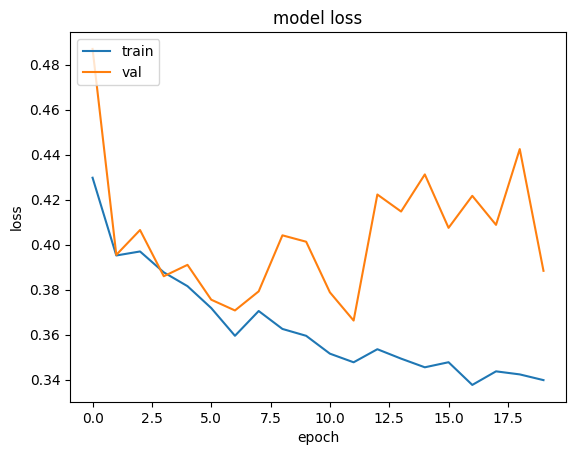

In [12]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [13]:
embeddings = model.layers[2].get_weights()[0]
most_similar("красный", mapper, embeddings)

['красный',
 'белый',
 'голубой',
 'лазоревый',
 'розовый',
 'знамя',
 'полотнище',
 'лавровый',
 'коричневый',
 'жёлтый']

In [14]:
most_similar("улица", mapper, embeddings)

['улица',
 'у́лица',
 'переулок',
 'набережная',
 'бульвар',
 'проспект',
 'ул',
 'микрорайон',
 'проезд',
 'тупик']

In [15]:
most_similar("должность", mapper, embeddings)

['должность',
 'пост',
 'заместитель',
 'помощник',
 'начальник',
 'назначить',
 'занимать',
 'киммел',
 'судьёй',
 'генерал-губернатор']

## CBOW

In [16]:
def gen_batches_cbow(sentences, window=5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = (sent[max(0, i-left_context_length):i] +
                           sent[i+1:i+right_context_length])

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(
                        X_context,
                        maxlen=window
                    )
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [17]:
#cbow negative sampling
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(7,))


embeddings_target = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                           output_dim=400)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=len(mapper.word2id),
                                            output_dim=400)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Lambda(
    lambda x: tf.reduce_sum(x, axis=1), output_shape=(400,))(embeddings_context)
dot = keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = keras.layers.Activation(activation="sigmoid")(dot)

model = keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [18]:
model.build([(None, 1), (None, 7)])

Больше 5 эпох начинает переобучаться

In [19]:
model.fit(gen_batches_cbow(mapper.sentences[:19000], window=7),
          validation_data=gen_batches_cbow(mapper.sentences[19000:], window=7),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=5)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.8189 - loss: 0.4059 - val_accuracy: 0.8829 - val_loss: 0.2876
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.8847 - loss: 0.2809 - val_accuracy: 0.8967 - val_loss: 0.2540
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9122 - loss: 0.2170 - val_accuracy: 0.8952 - val_loss: 0.2622
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9236 - loss: 0.1921 - val_accuracy: 0.9028 - val_loss: 0.2485
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9347 - loss: 0.1681 - val_accuracy: 0.8875 - val_loss: 0.3104


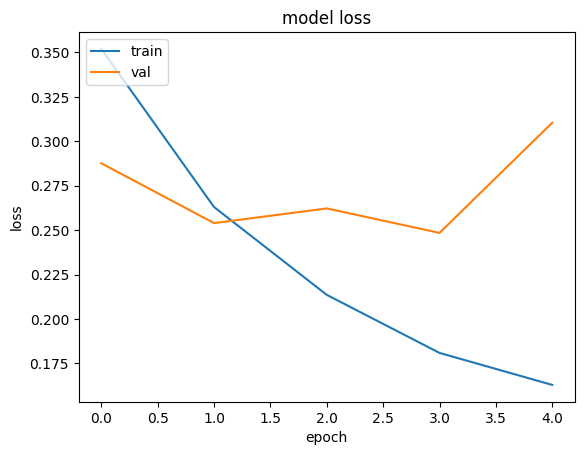

In [20]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [21]:
embeddings = model.layers[2].get_weights()[0]
most_similar("красный", mapper, embeddings)

['красный',
 'жёлтый',
 'белый',
 'голубой',
 'зелёный',
 'серый',
 'синий',
 'чёрный',
 'золотистый',
 'розовый']

In [22]:
most_similar("улица", mapper, embeddings)

['улица',
 'проспект',
 'переулок',
 'набережная',
 'бульвар',
 'шоссе',
 'ул',
 'посёлок',
 'проезд',
 'усадьба']

In [23]:
most_similar("должность", mapper, embeddings)

['должность',
 'пост',
 'заместитель',
 'кандидат',
 'помощник',
 'полномочие',
 'декан',
 'мид',
 'назначаться',
 'советник']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [24]:
%%time
w2v_model = gensim.models.Word2Vec(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0
)

CPU times: user 1min 49s, sys: 744 ms, total: 1min 49s
Wall time: 1min 8s


In [25]:
w2v_model.wv.most_similar("красный")

[('жёлтый', 0.9027318954467773),
 ('знамя', 0.9025858640670776),
 ('зелёный', 0.89304518699646),
 ('листоед', 0.8873950839042664),
 ('цвет', 0.8851983547210693),
 ('пятно', 0.8849399089813232),
 ('белый', 0.8844570517539978),
 ('олимпийский', 0.8828780055046082),
 ('летний', 0.8778494596481323),
 ('житомирский', 0.8771712183952332)]

In [26]:
w2v_model.wv.most_similar("улица")

[('переулок', 0.9313896894454956),
 ('проспект', 0.9300321936607361),
 ('ул', 0.9016808271408081),
 ('площадь', 0.9003891944885254),
 ('олимпийский', 0.8978049159049988),
 ('перепись', 0.8975342512130737),
 ('район', 0.8963459730148315),
 ('угол', 0.8942767381668091),
 ('проезд', 0.8932122588157654),
 ('житомирский', 0.8893752694129944)]

In [27]:
w2v_model.wv.most_similar("должность")

[('пост', 0.912059485912323),
 ('назначить', 0.8804394006729126),
 ('заместитель', 0.8792182207107544),
 ('код', 0.8728412985801697),
 ('км²', 0.872608482837677),
 ('телефонный', 0.8702865839004517),
 ('кафедра', 0.8686482906341553),
 ('житомирский', 0.8681756258010864),
 ('площадь', 0.868036150932312),
 ('27', 0.8674050569534302)]

In [28]:
%%time
ft_model = gensim.models.FastText(
    mapper.lemmatized_sents,
    vector_size=400,
    min_count=35,
    max_vocab_size=12000,
    window=7,
    epochs=10,
    sg=0,
    hs=0,
    negative=7,
    sample=1e-4,
    ns_exponent=0.5,
    cbow_mean=0,
    min_n=4,
    max_n=7
)

CPU times: user 13min 14s, sys: 2.92 s, total: 13min 17s
Wall time: 8min 14s


In [29]:
ft_model.wv.most_similar("красный")

[('опасный', 0.8994669318199158),
 ('романовский', 0.8950476050376892),
 ('черняховский', 0.8930620551109314),
 ('олимпийский', 0.8918232321739197),
 ('одесский', 0.8895543217658997),
 ('завьяловский', 0.8888218402862549),
 ('чёрный', 0.8879300355911255),
 ('зелёный', 0.8875018954277039),
 ('коростенский', 0.8864629864692688),
 ('харьковский', 0.8859188556671143)]

In [30]:
ft_model.wv.most_similar("улица")

[('проезд', 0.9205723404884338),
 ('проспект', 0.9125372767448425),
 ('переулок', 0.910415530204773),
 ('село', 0.9048760533332825),
 ('2001', 0.8998736143112183),
 ('200', 0.8977962732315063),
 ('2000', 0.8973424434661865),
 ('2006', 0.8958120942115784),
 ('2010', 0.8948951959609985),
 ('сын', 0.8947665691375732)]

In [31]:
ft_model.wv.most_similar("должность")

[('должный', 0.8775922060012817),
 ('стать', 0.8772475719451904),
 ('брать', 0.8760978579521179),
 ('александровский', 0.8760895729064941),
 ('избрать', 0.8757808208465576),
 ('назначить', 0.8729488253593445),
 ('свердловский', 0.8707107901573181),
 ('расположенный', 0.8705935478210449),
 ('николаевский', 0.8693963289260864),
 ('нить', 0.8693431615829468)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

In [32]:
data = pd.read_csv("labeled.csv")
mapper_for_labeled = WordIDMapper(corpus=data["comment"], window=7)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Creating vocab:   0%|          | 0/14412 [00:00<?, ?it/s]

In [33]:
labels = np.array(data["toxic"])
texts = mapper_for_labeled.lemmatized_sents

embeddings = np.zeros((len(texts), w2v_model.vector_size))
for i, text in enumerate(texts):
    word_embeddings = [
        w2v_model.wv[word] for word in text if word in w2v_model.wv
    ]
    if word_embeddings:
        embeddings[i] = np.mean(word_embeddings, axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42
)

In [34]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
preds = classifier.predict(X_test)
print(classification_report(y_test, preds, zero_division=0, digits=4))

              precision    recall  f1-score   support

         0.0     0.7599    0.9264    0.8350      1944
         1.0     0.7212    0.3940    0.5096       939

    accuracy                         0.7530      2883
   macro avg     0.7406    0.6602    0.6723      2883
weighted avg     0.7473    0.7530    0.7290      2883



# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.